### Supervised abalone regression

- I denne filen kommer jeg til å ta for meg trening og tuning av supervised regresjons modeller for abalone datasettet. Jeg kommer til å teste ut 3 forskjellige modeller og sammenligne hvilke av disse som prestere best.  Modellene jeg kommer til å bruke er RandomForestRegression, Ridge og Lasso.

- Siden deler av kommentarene i denne oppgaven vil være gjeldene for alle delene av oblig3 og 4 vil jeg skrive de samme eller veldig like kommentarer der hvor dette er hensiktsmessig i alle filene for disse oppgavene, men tilføre videre spesifikke kommentarer for den enkelte filen/oppgaven der hvor dette er hensiktsmessig.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer, get_scorer

In [3]:
df = pd.read_csv(r"..\..\oblig3_og_4\abalone.data", sep=",", names=["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [4]:
df_targets = df['Rings']
features = df.drop('Rings', axis=1)
features['Sex'] = pd.Series(np.array(LabelEncoder().fit_transform(features['Sex'])))
df_features = pd.DataFrame(StandardScaler().fit_transform(features), columns=features.columns)

In [5]:
global_random_state = 15

scoring = {
    'mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': get_scorer('r2'),
}  

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='r2', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

#### Beskrivelser av metoder for trening, tuning og testing av datasettet
- For å test og tune modellene har jeg laget en nested CV funksjon som bruker GridSearchCV som den indre loopen. Ut av denne funksjonen så får vi returnert den beste modellen for hver runde av den ytere loopen, de tilhørende scoring resultatene for både train og test oppsplittingen, og resultatene fra selve GridSearchCV modellen, som blant annet kan brukes til å visualisere parameter tuningen.

- Grunnen til at jeg har valgt å bruke et slik oppsett er at dette tillater meg å trene og tune modellene på hele datasettet uten at modellen overfiter til datasettet som en helhet. Dette gjør at resultatene du får ut fra denne typen tuning i større grad vil ha god overførings verdi til nye data for videre bruk.

- Måten dette oppnås på er at datasettet i yter loopen blir delt opp i for eks. 5 deler hvor du bruker 4 av disse dele til trening av modellene og den siste delen til testing. I den indre loopen splitter du igjen opp testdelen av data settet i for eks. 4 deler, hvor da 3 av disse brukes til trening av modellen og 1 del til testing/validering. På denne måte får du benyttet hele datasettet til trening og validering av modellene uten at den enkelte test delen av datasettet har blitt brukt til trening av modellen i forbindelse med sin vurdering av prestasjonen til modellen.

- Jeg har også lagt inn fuksjonalitet for å kunne endre antall spliter i ytter og inner loopene for treningen av modelene, noe som er kan være veldig nyttig for å kunne redusere kjøretiden til fuksjonen ved utprøving av forskjellige tuning parameter, noe som jeg kommer til å benytte meg av pga. eldre hardware.

- For oppdelingen av datasettet har jeg bruk StratifiedKFold slik at det oppnå så lik som mulig fordeling av target klassene mellom de forskjellige oppsplittingene av datasettet.  

- For å vurdere disse modellene har jeg valgt å bruke disse metricene "mean absolutte error", "mean squared error" og "r2". r2 er et mål på hvor mye av variasjonen i target verdiene som kan forklares av variasjonen i feature verdiene. Mean absolute error er et mål på den absolutte feil mengde for prediksjonen til modellene, og gir en indikasjon på hvor mye feil det er i prediksjonene. Mean squared error gir et bilde på hvor bra modellen håndtere eventuelle uteliggere, da feil verdier for disse blir forsterket gjennom kvadreringen i beregningen av feil marginen.

- For å unngå eksponentiell kjøretid ved tuningen av modellene kommer jeg til å dele opp tuningen i midre deler slik at kjøretiden blir lettere håndterbar. Utover dette kommer jeg til å gjennomføre noe videre tuning og testing av modellene som ikke vil være inkludert i de endelige fila av hensyn til å gjøre dokumentet mer oversiktig og lett forstålig, men jeg kommer til å dokumentere den helheltlige prossens slik at det mulig å se en rød tråd gjennom tuningen av modellene.

-	Pga. elde hardware og problemer med lang kjøre tid på flere av modellene når disse tunes med nested cross validation vil jeg derfor hvor det er hensiktsmessig, dele opp tuning i flere deler for å unngå eksponentiell kjøre tid. Dette er selvfølgelig ikke gunstig, da det kan være mulige påvirkende faktorer mellom tuning parametere som du ikke observere når disse tunes sekvensielt, men det dessverre nødvendig for noen av modellene. Der hvor det er mulig vil jeg heller bruke et redusert antall splitter av datasettet i kryss valideringen for å redusere kjøre tiden.

-	Etter at jeg har gjennomført tuningen av modellene kommer jeg til å kjøre en endelig test av modellene med de parameter verdiene jeg har kommet fram til. Dette gjør jeg slik GridSearchCV ikke skal velge de parameter verdiene som passer best for deler av datasettet, slik at jeg får et testresultat for de endelige modellene som er representative for hele datasettet.

-	For de avsluttende testene kommer jeg til å bruke en oppdeling av datasettet på 5 splitter for den ytre loopen og 4 for den indre. Dette gjøre at jeg vil få en god fordeling mellom training og test data og en typisk 80-20 splitt mellom traning og test i den ytre testing av datasettet.


#### RandomForestRegressor

- For å tune denne modellen så har jeg valgte å bruke disse parameterne, max_depth, min_samples_leaf, crriterion og n_estimatiors. Jeg valgte å brukes disse parameterne da jeg mener at disse er de mest relevante parameterne å bruke for denne typen modell, samt å hvis forståelse for hvordan dette påvirker prestasjonen til modellen uten at tuning og testing av modellen blir altfor tidkrevende.

- Max_depth definere hvor dype de forskjellige trene i modellen kan være, generelt vil dette gjøre at jo dypere treet er jo bedre kan disse tilpasse seg datasettet, men dette øker også risikoen for overfiting da du ofte kan få treer som tilpasser seg edge caser hvis du ikke implementere andre parameter for å unngå dette [1].

- min_samples_leaf er en parameter som brukes for å redusere overfiting på de forskjellige trærne, ved å sette en minimums begrensning på antall verdier en enkelt node i treet må inneholde. Dvs. desto mindre denne verdien er desto mer risiko for overfiting vil du få, samt at modellen lettere tilpasser seg edge caser.

- n_estimator er en parameter som definere hvor mange individuelle treere modellen kan inneholde. Dvs. desto høyere denne verdien er jo bedre kan modellen i utgangspunktet tilpasse seg et datasett, men dette øker også risikoen for overfiting samt kjøretiden til modellen [1].

- criterion er en parameter som gir deg muligheten til å velge mellom forskjellige funksjoner/algoritmer for å vurdere kvaliteten til en node split i modellen. Disse funksjonene har forskjellige styrker og svakheter som gjør at de kan være best tilpasset til forskjellige datasett [1].

- [1]: Scikit Learn. (u.å) RandomForestRegressor. Hentet 9. November 2025 fra https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html


In [ ]:
rf_params = {
    'max_depth': [5, 10, 25, 75],
    'min_samples_leaf': [2, 8, 16],
    'criterion': ['squared_error', 'poisson'],
    'n_estimators': [50, 150, 500, 1000],
}

rf_estimators, rf_scores_train, rf_scores_test, rf_cv_results = train(df_features, df_targets,
    RandomForestRegressor(random_state=global_random_state),
    rf_params, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


<Axes: xlabel='param_criterion', ylabel='mean_test_r2'>

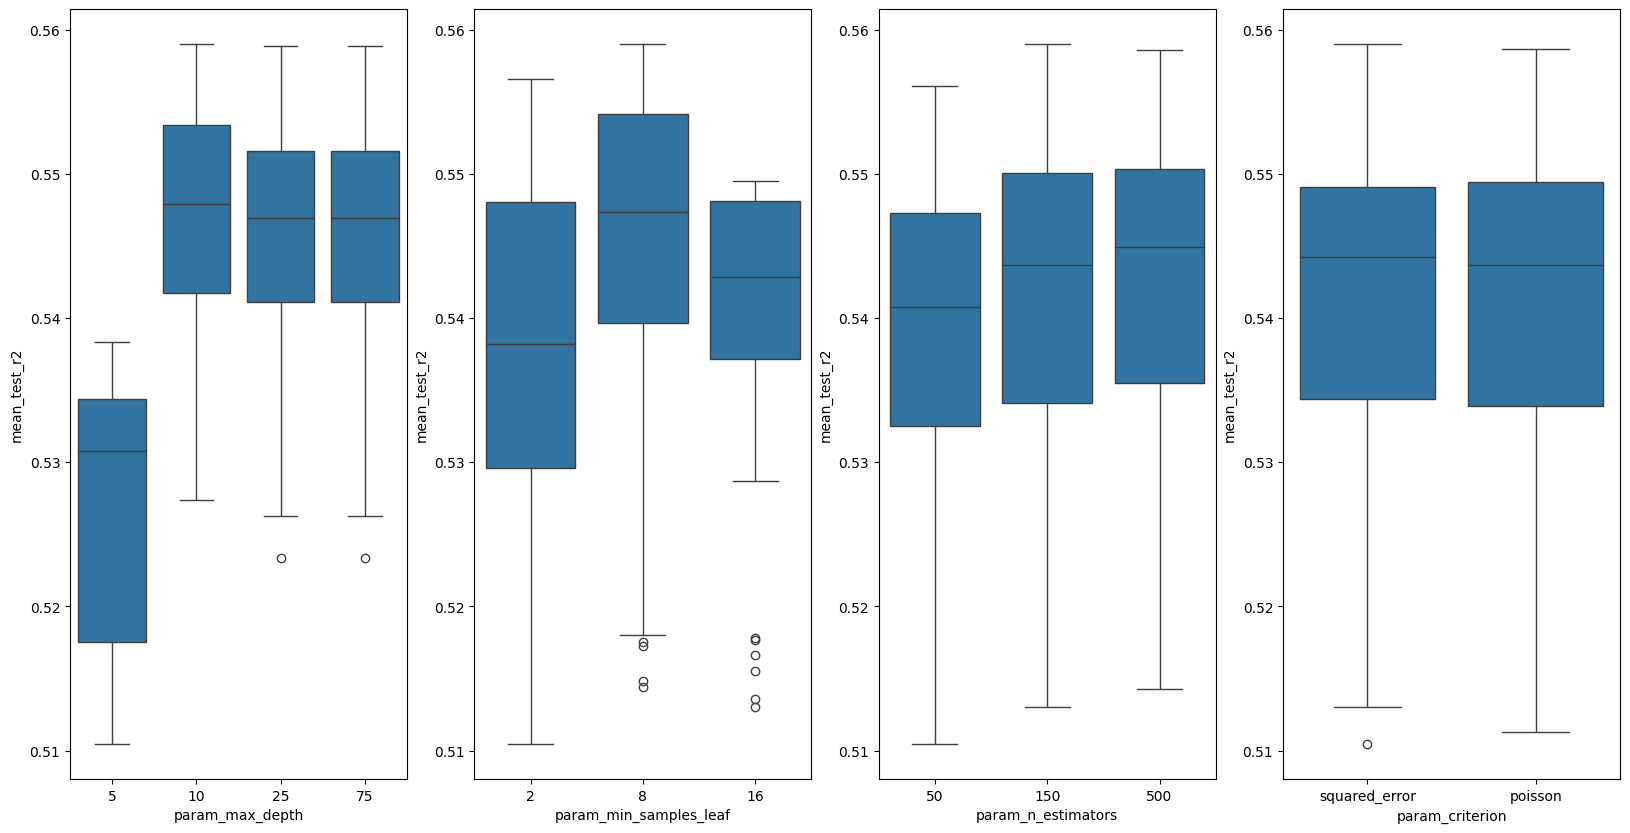

In [13]:
fig, ax = plt.subplots(1,4, figsize=(20,10))
sb.boxplot(data=rf_cv_results, x='param_max_depth', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=rf_cv_results, x='param_min_samples_leaf', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=rf_cv_results, x='param_n_estimators', y='mean_test_r2', ax=ax[2])
sb.boxplot(data=rf_cv_results, x='param_criterion', y='mean_test_r2', ax=ax[3])


In [14]:
rf_params = {
    'max_depth': [10, 15],
    'min_samples_leaf': [8],
    'criterion': ['squared_error'],
    'n_estimators': [500, 1000],
}

rf_estimators_2, rf_scores_train_2, rf_scores_test_2, rf_cv_results_2 = train(df_features, df_targets,
    RandomForestRegressor(random_state=global_random_state),
    rf_params, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


<Axes: xlabel='param_n_estimators', ylabel='mean_test_r2'>

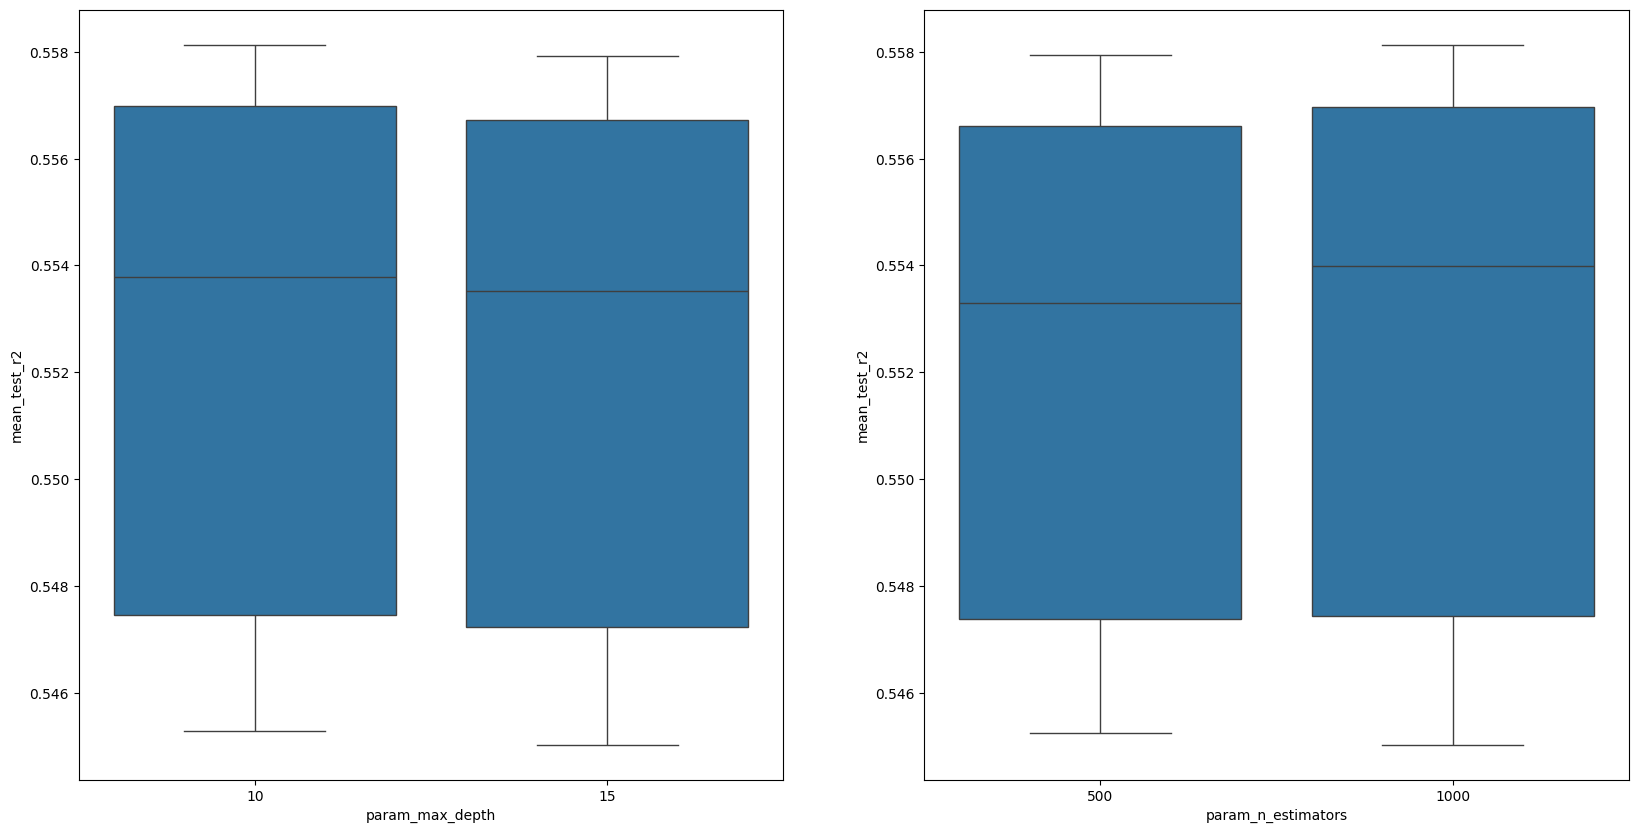

In [17]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
sb.boxplot(data=rf_cv_results_2, x='param_max_depth', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=rf_cv_results_2, x='param_n_estimators', y='mean_test_r2', ax=ax[1])

In [6]:
rf_params = {
    'max_depth': [10],
    'min_samples_leaf': [8],
    'criterion': ['squared_error'],
    'n_estimators': [1000],
}

rf_estimators_final, rf_scores_train_final, rf_scores_test_final, rf_cv_results_final = train(df_features, df_targets,
    RandomForestRegressor(random_state=global_random_state),
    rf_params, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


In [9]:
rf_scores_test_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.501076,-4.561270,0.561307
std,0.017167,0.238996,0.014897
min,-1.528020,-4.939848,0.539725
25%,-1.502232,-4.610715,0.557313
50%,-1.501815,-4.498417,0.563306
75%,-1.490843,-4.456419,0.565221
max,-1.482468,-4.300950,0.580971


In [10]:
rf_scores_train_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.207375,-2.971333,0.714112
std,0.007480,0.058484,0.004330
min,-1.214710,-3.027262,0.709708
25%,-1.213757,-3.009267,0.711339
50%,-1.209276,-2.996656,0.712295
75%,-1.200922,-2.937916,0.717159
max,-1.198210,-2.885562,0.720057


In [ ]:
ridge_params = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'max_iter': [1000, 5000, 10000],
    'tol': [0.1, 0.01, 1e-3, 1e-4, 1e-5],
}

ridge_estimators, ridge_scores_train, ridge_scores_test, ridge_cv_results = train(df_features, df_targets,
    Ridge(random_state=global_random_state),
    ridge_params, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


<Axes: xlabel='param_tol', ylabel='mean_test_r2'>

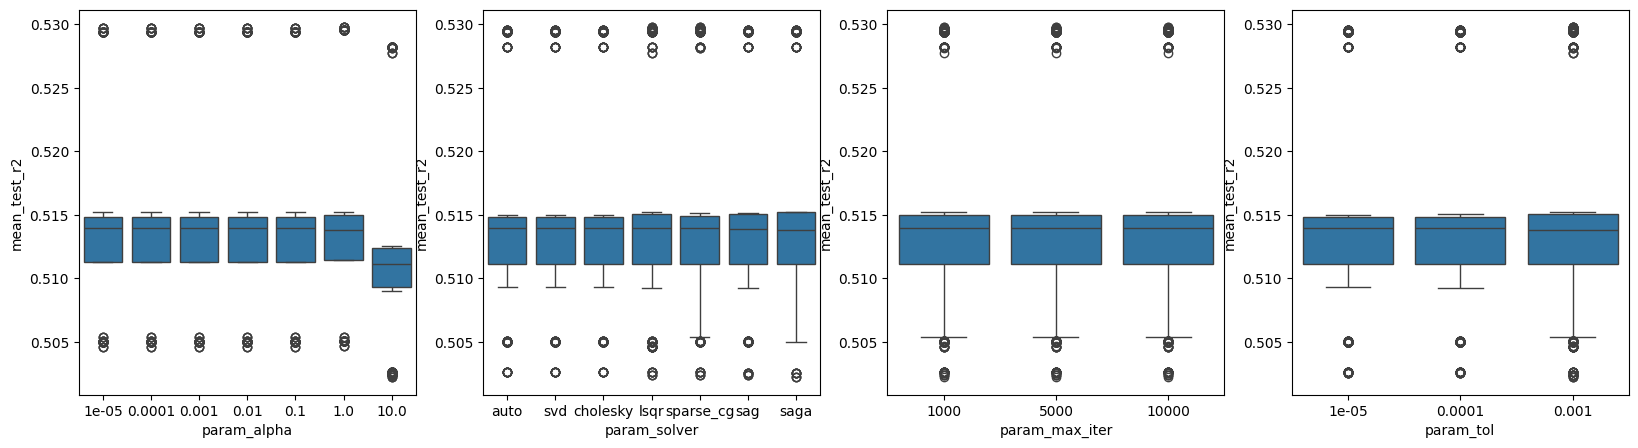

In [24]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
sb.boxplot(data=ridge_cv_results, x='param_alpha', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=ridge_cv_results, x='param_solver', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=ridge_cv_results, x='param_max_iter', y='mean_test_r2', ax=ax[2])
sb.boxplot(data=ridge_cv_results, x='param_tol', y='mean_test_r2', ax=ax[3])

In [7]:
ridge_params = {
    'alpha': [0.01, 0.1, 1],
    'solver': ['lsqr', 'sparse_cg'],
    'max_iter': [250, 500, 1000],
    'tol': [1e-2, 1e-3, 1e-4],
}

ridge_estimators_2, ridge_scores_train_2, ridge_scores_test_2, ridge_cv_results_2 = train(df_features, df_targets,
    Ridge(random_state=global_random_state),
    ridge_params, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


<Axes: xlabel='param_tol', ylabel='mean_test_r2'>

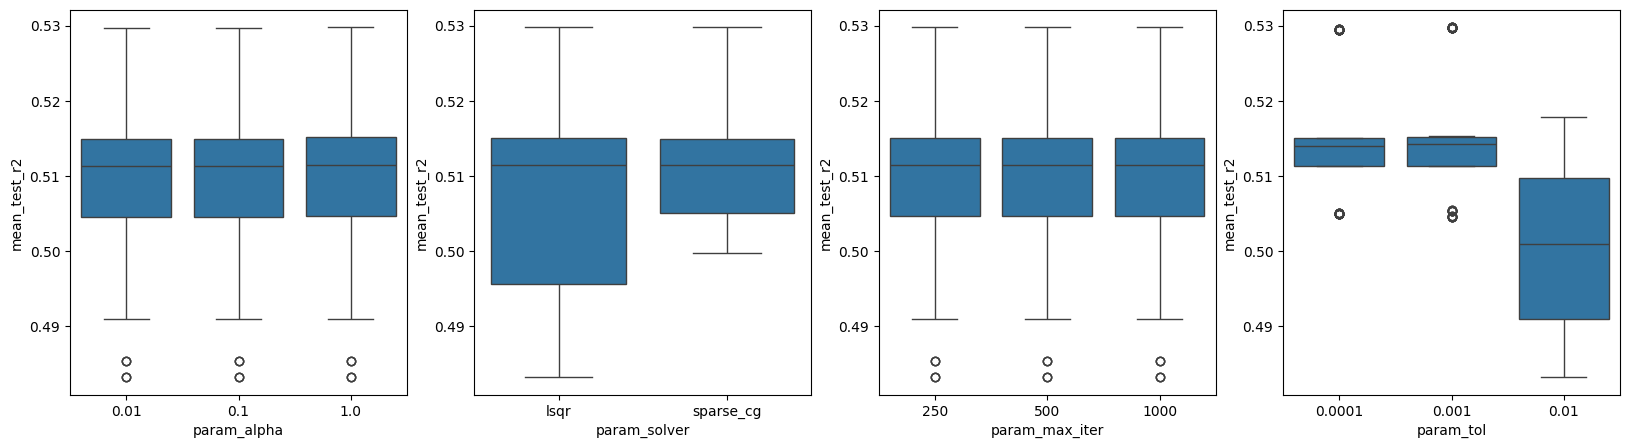

In [11]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
sb.boxplot(data=ridge_cv_results_2, x='param_alpha', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=ridge_cv_results_2, x='param_solver', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=ridge_cv_results_2, x='param_max_iter', y='mean_test_r2', ax=ax[2])
sb.boxplot(data=ridge_cv_results_2, x='param_tol', y='mean_test_r2', ax=ax[3])

In [12]:
ridge_params = {
    'alpha': [1],
    'solver': ['sparse_cg'],
    'max_iter': [250],
    'tol': [1e-3],
}

ridge_estimators_final, ridge_scores_train_final, ridge_scores_test_final, ridge_cv_results_final = train(df_features, df_targets,
    Ridge(random_state=global_random_state),
    ridge_params, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklear

*
*
*
*
*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


In [13]:
ridge_scores_test_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.614924,-5.014033,0.517375
std,0.035532,0.335862,0.034295
min,-1.642319,-5.506848,0.462738
25%,-1.634086,-5.038070,0.516281
50%,-1.626798,-5.036747,0.520671
75%,-1.617992,-4.919873,0.530696
max,-1.553425,-4.568627,0.556490


In [14]:
ridge_scores_train_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.607365,-4.897758,0.528729
std,0.011114,0.061723,0.006008
min,-1.625666,-4.995695,0.520369
25%,-1.609230,-4.908742,0.526724
50%,-1.603765,-4.878373,0.529134
75%,-1.600736,-4.876889,0.530488
max,-1.597429,-4.829089,0.536927


#### Ridge Regression
- For denne type algoritme er det i utgangspunktet ikke en betydelig mengde med parametere som det er hensiktsmessig å tune, jeg har valg å bruke alpha, solver og max_iter for trening og tuning for denne algoritmen [2].

- Alpha parameteren er i utgangspunktet den viktigste parameteren for denne algoritemen og kontrollere regulariserings stryken til modellen gjennom multiplikasjon med L2 delen av uttrykket til linær regresjon, det er denne parameteren som gjør den algoritmen forskjellig fra standard linjer regresjon og Lasso regresjon som manipulere L1 delen av uttrykket til linjer regresjon [2].

- Solver parameteren definere forskjellige underliggende algoritmer som modellene bruker, disse har forskjellige fordeler og ulemper og gitt forskjellige karakteristikker for datasettet kan forskjelig av disse solverne gi bedre eller dårligere resultater [2].

- max_iter parameteren lar deg sette begrensninger på antall iterasjoner som modellen får kjøre, denne parameteren er i utgangspunktet kun relevant for noen av solver parameterne [2].

- For denne algoritmen så er det alpha=1 og max_iter=1000 som gir best resultater ved 4 av ytter loopene og på den siste ytter loopen så er det alpha=0.1 og max_iter=1000 som gir best resultat. For ytter loopene så er det deafault verdien ("auto") for solver som gir best resultat.  

- Når vi ser på resultatene for denne algoritmen så ser vi at det ikke er stor forskjeller mellom test og training delen av datasettet noe som tyder på at modellen ikke i betydelig grad overfiter ved trening av modellen på dette datasettet.Videre ser vi at test resultatene gir oss en r2 korrelasjon på 0.52 som tyder på at modellen gir oss en moderat korrelasjon til å predikere target verdiene. Med et gjennomsnitt for Mean_absolute_error ligger på 1.61 ut i fra en total range på 29 tyder dette på relativt lave feil-verdier for disse prediksjonene. Modellene gir et gjennomsnitt for mean_squared_error på 
5.01 tyder også på at det heller ikke er mange store uteliggere i prediksjonene til modellene. I likhet med RandomForest tyder dette på at algoritmene klarer å levere en modell med relativt lav feil margin, men at selv korrelasjonen til modellene ikke er høy nok til å gi sterke prediksjoner.

ref[2]: Scikit Learn. (u.å) Ridge. Hentet 9. November 2025 fra https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [ ]:
lasso_params = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'max_iter': [500, 1000, 5000, 10000],
}

lasso_estimators, lasso_scores_train, lasso_scores_test, lasso_cv_results = train(df_features, df_targets,
    Lasso(random_state=global_random_state),
    lasso_params, outer_splits=5, inner_splits=4)

<Axes: xlabel='param_max_iter', ylabel='mean_test_r2'>

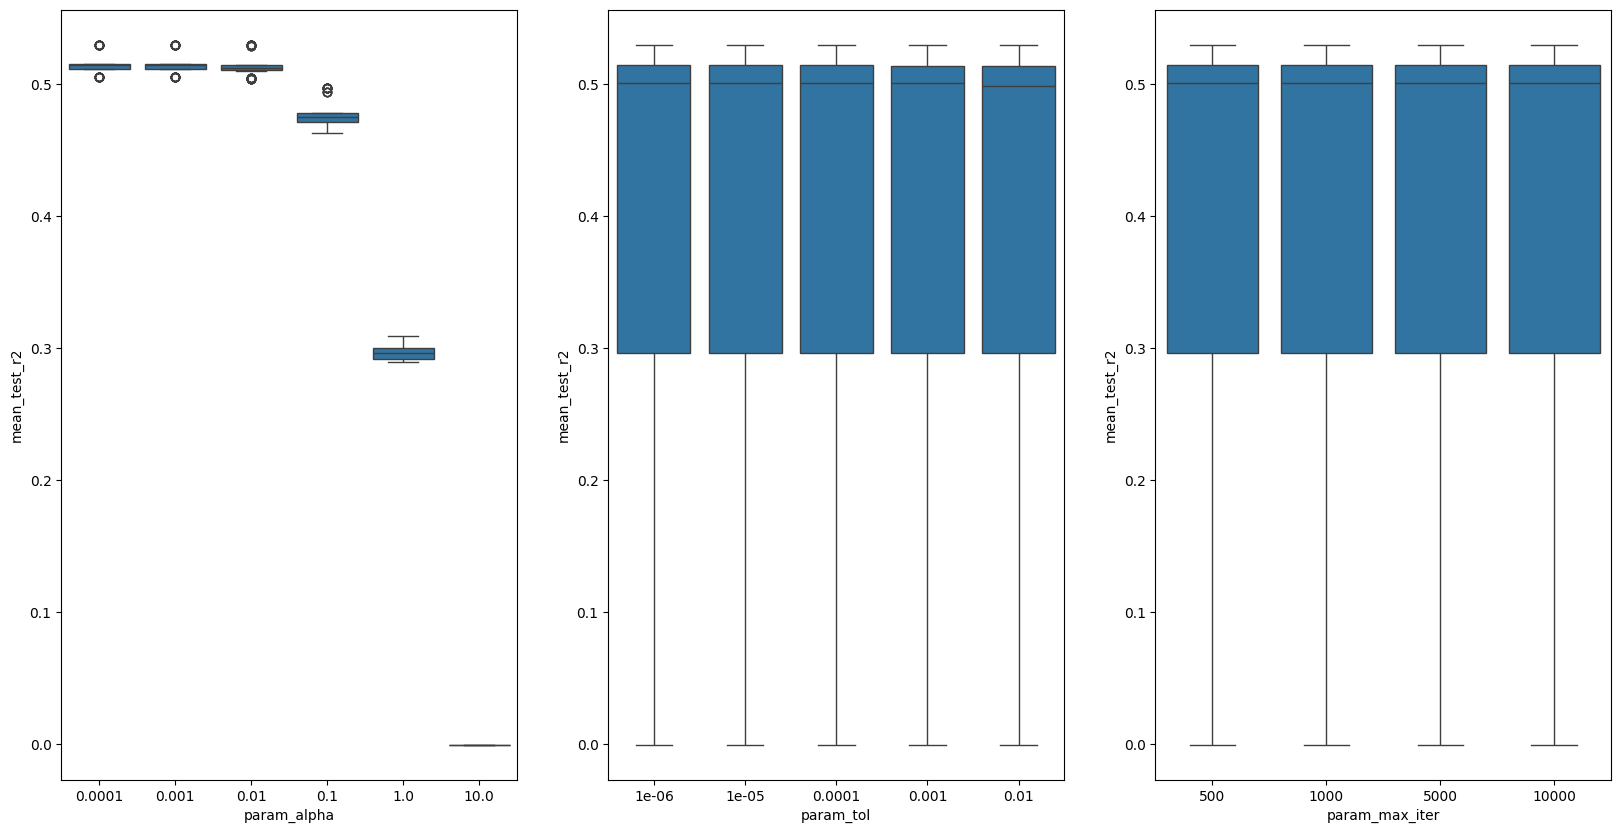

In [21]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
sb.boxplot(data=lasso_cv_results, x='param_alpha', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=lasso_cv_results, x='param_tol', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=lasso_cv_results, x='param_max_iter', y='mean_test_r2', ax=ax[2])


In [15]:
lasso_params = {
    'alpha': [0.0001, 0.001, 0.01],
    'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'max_iter': [500, 1000, 5000, 10000],
}

lasso_estimators_2, lasso_scores_train_2, lasso_scores_test_2, lasso_cv_results_2 = train(df_features, df_targets,
    Lasso(random_state=global_random_state),
    lasso_params, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.019e+03, tolerance: 2.579e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objectiv

*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.681e+02, tolerance: 2.588e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.412e+03, tolerance: 2.600e+02
  model = cd_fast.enet_coordinate_descen

*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.403e+03, tolerance: 2.621e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.453e+02, tolerance: 2.584e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.332e+03, tolerance: 2.610e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.827e-01, tolerance: 2.615e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.251e+03, tolerance: 2.605e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.246e+03, tolerance: 2.614e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.268e+01, tolerance: 3.485e+00
  model = cd_fast.enet_coordinate_descent(


<Axes: xlabel='param_max_iter', ylabel='mean_test_r2'>

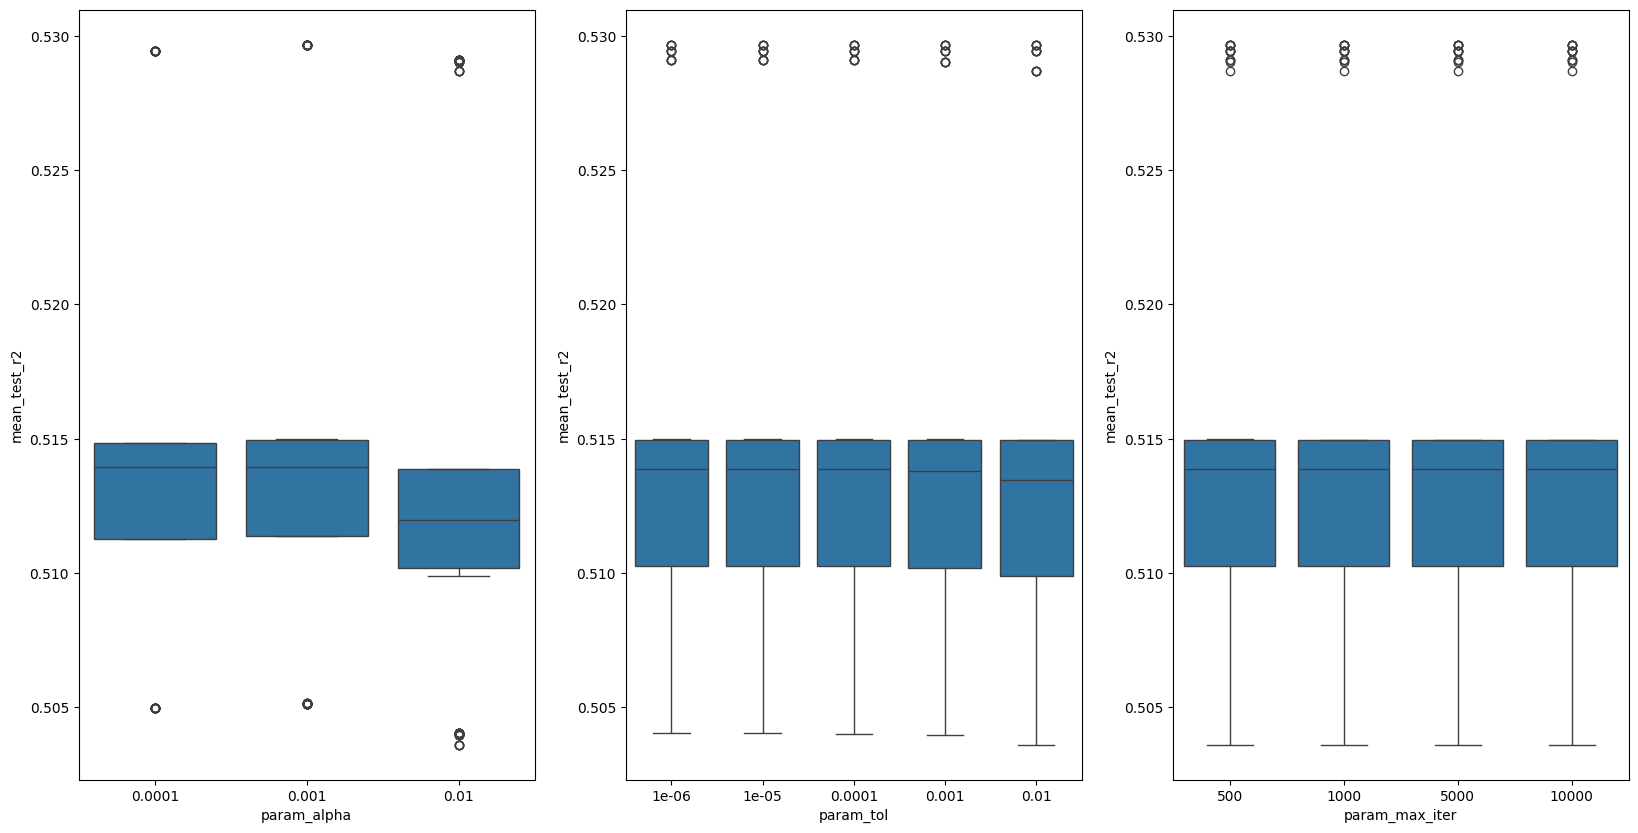

In [17]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
sb.boxplot(data=lasso_cv_results_2, x='param_alpha', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=lasso_cv_results_2, x='param_tol', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=lasso_cv_results_2, x='param_max_iter', y='mean_test_r2', ax=ax[2])

In [ ]:
lasso_params = {
    'alpha': [0.001],
    'tol': [1e-4],
    'max_iter': [500],
}

lasso_estimators_final, lasso_scores_train_final, lasso_scores_test_final, lasso_cv_results_final = train(df_features, df_targets,
    Lasso(random_state=global_random_state),
    lasso_params, outer_splits=5, inner_splits=4)

In [19]:
lasso_scores_test_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.614877,-5.013517,0.517424
std,0.035542,0.333048,0.034059
min,-1.642647,-5.501324,0.463277
25%,-1.634361,-5.036441,0.516437
50%,-1.626300,-5.034623,0.520118
75%,-1.617553,-4.925550,0.530894
max,-1.553523,-4.569648,0.556391


In [20]:
lasso_scores_train_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.607364,-4.897715,0.528733
std,0.011106,0.061642,0.006002
min,-1.625639,-4.995543,0.520384
25%,-1.609216,-4.908606,0.526720
50%,-1.603833,-4.878414,0.529147
75%,-1.600769,-4.876872,0.530490
max,-1.597363,-4.829138,0.536922


#### Lasso Regression
- For denne modellen har jeg valg å tune disse parameterne 'alpha', 'tol' og 'max_iter'.

- Akkurat som for RidgeRegressor så er alpha den viktigste parameteren du kan tune for denne algoritmen og det som gjør det forskjellig fra linjer regresjon og ridge regresjon [3].

- tol påvirker avslutnings kriteriet til modellen og desto lavere tol er jo lavere endringer kreves det for at modellen skal avslutte [3].

- max_iter setter en begrensning på det maksimale antallet iterasjoner modellen kan kjøre [3].

- For denne algoritmen så er det alpha=0.001 som gir best resultat, samt default max_iter (1000), for tol er det default (0.0001) som gir best resultat for 3 av ytter loopene og tol=0.1 og tol=0.001 gir best resultat for 1 ytter loop hver seg. Når vi ser på plotene for tuning parameterne så er det lite som tyder på at verdiene for 'tol' og 'max_iter' har veldig stor påvirkning på resultatene, mens vi ser at for alpha er det sannsynlig at denne vil påvirke mye.

- Når vi ser på resultatene for denne algoritmen så ser vi at det ikke er stor forskjeller mellom test og training delen av datasettet noe som tyder på at i likhet med rigde-modellene at modellene ikke i betydelig grad overfiter ved trening av modellene på dette datasettet. Videre ser vi at test resultatene gir oss en gjennomsnittlig r2 korrelasjon på 0.51 som tyder på at modellen gir oss en moderat korrelasjon til å predikere target verdiene. Videre for vi et gjennomsnitt for mean_absolute_error på 1.62, dette tyder på relativt lave feil-verdier for disse prediksjonene gitt total rangen til target verdiene. Modellene gir et gjennomsnitt for mean_squared_error på 5.01 som tyder på at modellen håndtere utliggere i test dataene relativt bra. I likhet med de andre modellene tyder dette på at algoritmen klarer å levere en modell med relativt lav feil margin, men at selv korrelasjonen til modellene ikke er høy nok til å gi gode prediksjonen for alder til abalonene.

ref [3]: Scikit Learn. (u.å) Lasso. Hentet 9. November 2025 fra https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [21]:
slutt_resultat = pd.DataFrame({
    'Metric': ['Mean absolute error:','Mean squared error:','r2:'],
    'RandomForest Train': [rf_scores_train_final["mean_absolute_error"].mean(), rf_scores_train_final["mean_squared_error"].mean(), rf_scores_train_final['r2'].mean()],
    'RandomForest Test': [rf_scores_test_final["mean_absolute_error"].mean(), rf_scores_test_final["mean_squared_error"].mean(), rf_scores_test_final['r2'].mean()],
    'Ridge Train': [ridge_scores_train_final["mean_absolute_error"].mean(), ridge_scores_train_final["mean_squared_error"].mean(), ridge_scores_train_final['r2'].mean()],
    'Ridge Test': [ridge_scores_test_final["mean_absolute_error"].mean(), ridge_scores_test_final["mean_squared_error"].mean(), ridge_scores_test_final['r2'].mean()],
    'Lasso Train': [lasso_scores_train_final["mean_absolute_error"].mean(), lasso_scores_train_final["mean_squared_error"].mean(), lasso_scores_train_final['r2'].mean()],
    'Lasso Test': [lasso_scores_test_final["mean_absolute_error"].mean(), lasso_scores_test_final["mean_squared_error"].mean(), lasso_scores_test_final['r2'].mean()],
})
slutt_resultat.set_index('Metric', inplace=True)
slutt_resultat

,RandomForest Train,RandomForest Test,Ridge Train,Ridge Test,Lasso Train,Lasso Test
Metric,,,,,,
Mean absolute error:,-1.207375,-1.501076,-1.607365,-1.614924,-1.607364,-1.614877
Mean squared error:,-2.971333,-4.561270,-4.897758,-5.014033,-4.897715,-5.013517
r2:,0.714112,0.561307,0.528729,0.517375,0.528733,0.517424


### Avsluttende vurdering
 - Ut i fra totalen av resultatene så ser det ut til at det er RandomForestRegressor som gir best resultater for dette datasettet med en avsluttene modell "RandomForestRegressor(max_depth=12, min_samples_leaf=8, n_estimators=500)" eller "RandomForestRegressor(max_depth=8, min_samples_leaf=12, n_estimators=500)". Ut i fra tuning plotene til modellene så ser det ikke ut som det vil være noe stor forskjell mellom disse to modellen.

 - Hvis vi ser på forskjellene for RandomForest kontra Ridge og Lasso så prestere RandomForest bedre for alle test metricene som er inkluderet, men det er ikke stor forskjeller i prestasjonene mellom disse algoritmene. Det imidlertid større forskjell mellom train og test resultatene for RandomForest enn det er for Ridge og Lasso, dette tyder på at RandomForest har større utfordringer med overfiting kontra de andre to algoritmene for dette datasettet. Det er også vært å nevne at RandomForest er betydelig mer tidkrevende å trene og tune på en god måte med nested CV, så ved videre bruk av denne typen modell vil det være viktig å kjøre en vurdering i forhold til tids bruk kontra prestasjon av modellen. 

 - Totaltsett tyder resultatene for dette datasettet på at det kan gi prediksjoner med relativt lav feilmargin når du ser mean absolute error opp mot toalt rangen av target verdier i datasettet, men at korrelasjonen mellom feature verdiene og target verdiene ikke er så sterk. Dette var forsåvitt også påpekt i kilden til datasete, og at det muligens var behov for mere data grunnlag som tar høyde for forskjellig miljø påvirkning for å bedre kunne estimere alder/ringer for adalonene [4].

 ref [4]: UC Irvine. (u.å) Abalone. Hentet 9. November 2025 fra https://archive.ics.uci.edu/dataset/1/abalone